<a href="https://colab.research.google.com/github/rohankodavalla/Bixi_Analysis/blob/main/bixi_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import zipfile
import requests
import io


In [ ]:
#download the zip file from the bixi 2024 URL
url = 'https://s3.ca-central-1.amazonaws.com/cdn.bixi.com/wp-content/uploads/2025/01/DonneesOuvertes2024_010203040506070809101112.zip'
response = requests.get(url)

#now we open the zip file from the response content
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    #list all files inside the zip to see the contents
    print(z.namelist())

    #extract the first csv file (assuming the first one is jan data)
    with z.open(z.namelist()[0]) as csv_file:
        bixi_data = pd.read_csv(csv_file)


['DonneesOuvertes (2).csv']


In [ ]:
#lets see the first few rows to check the data
bixi_data.head()

,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE,ENDSTATIONNAME,ENDSTATIONARRONDISSEMENT,ENDSTATIONLATITUDE,ENDSTATIONLONGITUDE,STARTTIMEMS,ENDTIMEMS,STARTTIME,HOUR,DAY_OF_WEEK
0,Métro Champ-de-Mars (Viger / Sanguinet),Ville-Marie,45.510253,-73.556777,St-Antoine / Jean-Paul Riopelle,Ville-Marie,45.502940,-73.560640,1704230756167,1.704231e+12,2024-01-02 21:25:56.167,21,Tuesday
1,Métro Place-d'Armes (Viger / St-Urbain),Ville-Marie,45.506314,-73.559671,de Maisonneuve / Aylmer (est),Ville-Marie,45.505386,-73.570432,1704232888826,1.704233e+12,2024-01-02 22:01:28.826,22,Tuesday
2,Émile-Duployé / Sherbrooke,Le Plateau-Mont-Royal,45.527195,-73.564526,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,1704238154678,1.704239e+12,2024-01-02 23:29:14.678,23,Tuesday
3,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Roy / St-André,Le Plateau-Mont-Royal,45.521564,-73.570367,1704232695740,1.704233e+12,2024-01-02 21:58:15.740,21,Tuesday
4,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,1704243796167,1.704244e+12,2024-01-03 01:03:16.167,1,Wednesday


In [ ]:
#now check data types and column info
bixi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13275326 entries, 0 to 13275325
Data columns (total 13 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   STARTSTATIONNAME            object        
 1   STARTSTATIONARRONDISSEMENT  object        
 2   STARTSTATIONLATITUDE        float64       
 3   STARTSTATIONLONGITUDE       float64       
 4   ENDSTATIONNAME              object        
 5   ENDSTATIONARRONDISSEMENT    object        
 6   ENDSTATIONLATITUDE          float64       
 7   ENDSTATIONLONGITUDE         float64       
 8   STARTTIMEMS                 int64         
 9   ENDTIMEMS                   float64       
 10  STARTTIME                   datetime64[ns]
 11  HOUR                        int32         
 12  DAY_OF_WEEK                 object        
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(5)
memory usage: 1.2+ GB


In [ ]:
#now convert the STARTTIMEMS column from Unix Epoch (milliseconds) to datetime
bixi_data['STARTTIME'] = pd.to_datetime(bixi_data['STARTTIMEMS'], unit='ms')

#extract hour and day of the week for analysis
bixi_data['HOUR'] = bixi_data['STARTTIME'].dt.hour
bixi_data['DAY_OF_WEEK'] = bixi_data['STARTTIME'].dt.day_name()

#lets check the updated df
bixi_data[['STARTSTATIONNAME', 'STARTSTATIONARRONDISSEMENT', 'STARTTIME', 'HOUR', 'DAY_OF_WEEK']].head()


,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTTIME,HOUR,DAY_OF_WEEK
0,Métro Champ-de-Mars (Viger / Sanguinet),Ville-Marie,2024-01-02 21:25:56.167,21,Tuesday
1,Métro Place-d'Armes (Viger / St-Urbain),Ville-Marie,2024-01-02 22:01:28.826,22,Tuesday
2,Émile-Duployé / Sherbrooke,Le Plateau-Mont-Royal,2024-01-02 23:29:14.678,23,Tuesday
3,Marmier / St-Denis,Rosemont - La Petite-Patrie,2024-01-02 21:58:15.740,21,Tuesday
4,Marmier / St-Denis,Rosemont - La Petite-Patrie,2024-01-03 01:03:16.167,1,Wednesday


<ipython-input-24-f84b320ef27c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=peak_usage.head(10).values, y=peak_usage.head(10).index, palette='viridis')


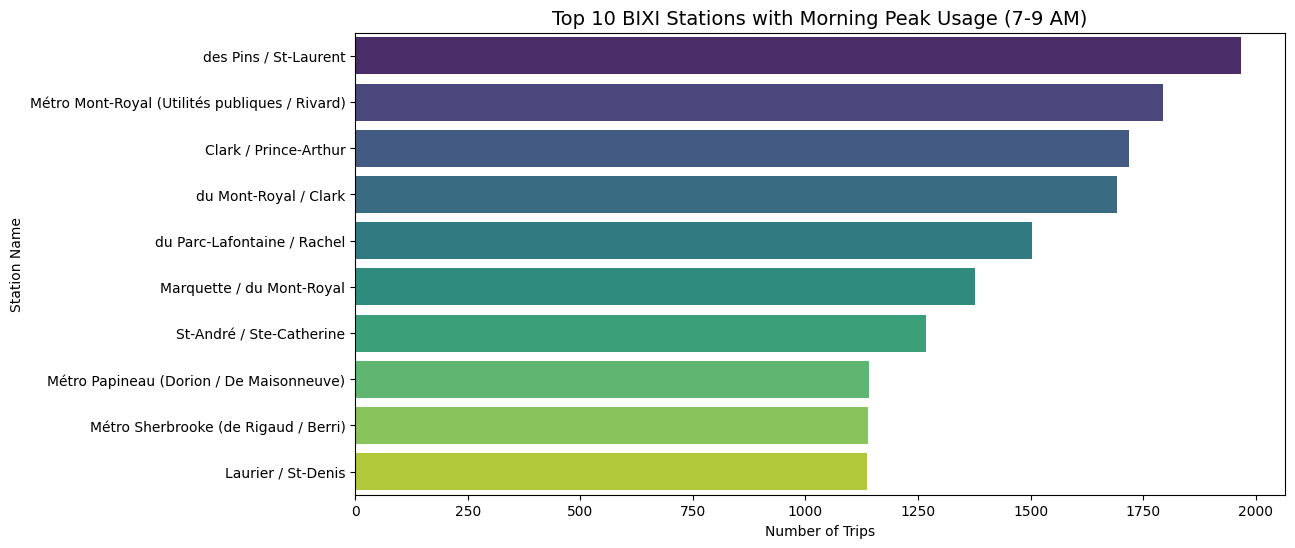

In [ ]:
#now we do start analysis, lets set peak hours, see which stations are busiest at that hour and then viz it
# 1. peak usage analysis (7-9 AM)
peak_hours = bixi_data[(bixi_data['HOUR'] >= 7) & (bixi_data['HOUR'] <= 9)]

# 2. top stations with high morning usage
peak_usage = peak_hours.groupby('STARTSTATIONNAME').size().sort_values(ascending=False)

#visualize the top stations in the morning (7-9 AM)
plt.figure(figsize=(12, 6))
sns.barplot(x=peak_usage.head(10).values, y=peak_usage.head(10).index, palette='viridis')
plt.title('Top 10 BIXI Stations with Morning Peak Usage (7-9 AM)', fontsize=14)
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.show()

In [ ]:
#now let suggest some rebalancing recommendations (stations with unusually high usage),
#for example setting threshold = 500 (if a station has more than 500 trips, it's considered to need rebalancing)
def recommend_rebalancing(data, threshold=500):
    recommendations = data[data > threshold]
    return recommendations

rebalancing_needed = recommend_rebalancing(peak_usage)
print("\nStations Needing Rebalancing in the Morning:")
print(rebalancing_needed)


Stations Needing Rebalancing in the Morning:
STARTSTATIONNAME
des Pins / St-Laurent                                      1967
Métro Mont-Royal (Utilités publiques / Rivard)             1794
Clark / Prince-Arthur                                      1718
du Mont-Royal / Clark                                      1692
du Parc-Lafontaine / Rachel                                1504
                                                           ... 
CÉGEP du Vieux-Montréal (Ontario / de l'Hôtel-de-Ville)     503
Jeanne-Mance / René-Lévesque                                503
Ste-Catherine / Bishop                                      502
Villeneuve / St-Dominique                                   501
Drolet / Beaubien                                           501
Length: 89, dtype: int64


In [ ]:
#so des Pins is part of Plateau
#now lets filter trips that started in Plateau at 7 AM
plateau_peak = bixi_data[(bixi_data['STARTSTATIONARRONDISSEMENT'].str.contains('Plateau', case=False, na=False)) & (bixi_data['HOUR'] == 7)] #case false>capitals etc are ignored, na> treats null as false

#we got plateau_peak, lets count the number of trips starting at 7 AM in Plateau
peak_count = plateau_peak.groupby('STARTSTATIONNAME').size().sort_values(ascending=False)

#let see the top 10 busiest stations in Plateau at 7 AM
peak_count.head(10)


,0
STARTSTATIONNAME,
des Pins / St-Laurent,1190
Métro Mont-Royal (Utilités publiques / Rivard),1111
Clark / Prince-Arthur,1092
du Mont-Royal / Clark,963
du Parc-Lafontaine / Rachel,782
Marquette / du Mont-Royal,733
Gilford / St-Denis,732
Métro Sherbrooke (de Rigaud / Berri),672
Milton / St-Laurent,642


<ipython-input-34-677e31348f83>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=peak_count.head(10).values, y=peak_count.head(10).index, palette='viridis')


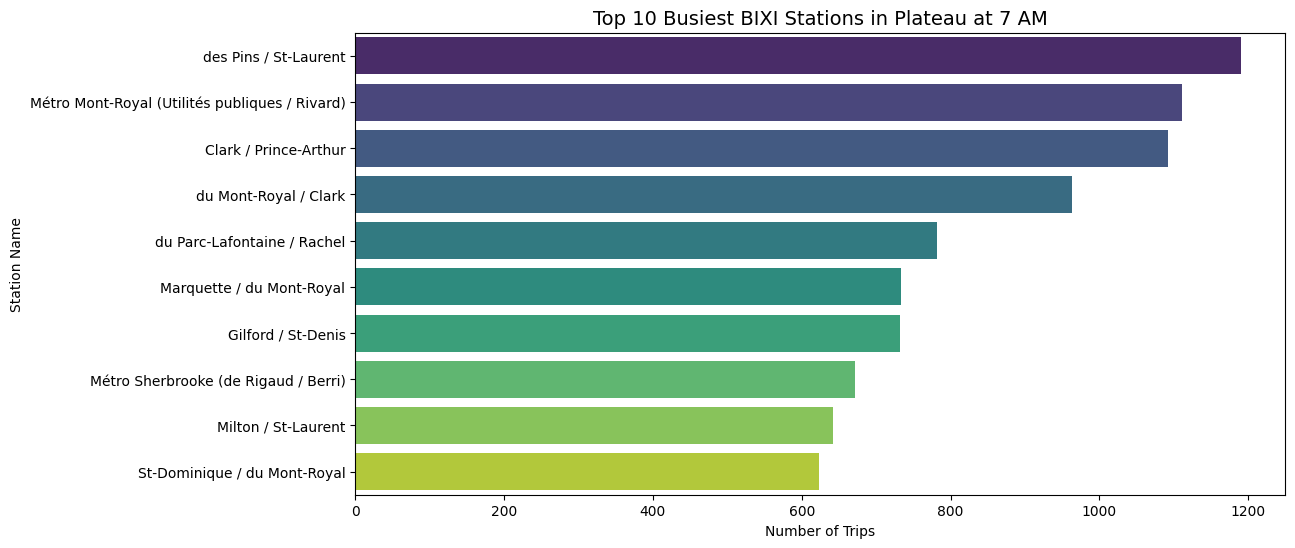


Plateau does not need additional BIXIs at 7 AM based on current data.


In [ ]:
#the final part, let viz this data
import seaborn as sns
import matplotlib.pyplot as plt

#plotting the top 10 busiest stations in Plateau at 7 AM
plt.figure(figsize=(12, 6))
sns.barplot(x=peak_count.head(10).values, y=peak_count.head(10).index, palette='viridis')
plt.title('Top 10 Busiest BIXI Stations in Plateau at 7 AM', fontsize=14)
plt.xlabel('Number of Trips')
plt.ylabel('Station Name')
plt.show()

#highlighting Plateau-specific need for rebalancing
if 'Plateau' in rebalancing_needed.index:
    print("\nSpoiler Alert: Plateau needs more BIXIs at 7 AM!")
else:
    print("\nPlateau does not need additional BIXIs at 7 AM based on current data.")



**If you've come this far, you must now be wondering-**

Q. *In rebalancing_needed step, it shows street - des Pins / St-Laurent etc.(which are part of Plateau) needs rebalancing, but in this viz, it shows Plateau doesn't need rebalacing, why ?*

A. The rebalancing_needed part looks at stations with high trip counts overall (from 7-9 AM) and checks if they exceed a threshold, but it does not specifically focus on Plateau as a district.
The Plateau-specific analysis focuses on just Plateau and checks only 7 AM data, without considering the rebalancing threshold



Plateau Stations Needing Rebalancing (7-9 AM):
STARTSTATIONNAME
des Pins / St-Laurent                                1967
Métro Mont-Royal (Utilités publiques / Rivard)       1794
Clark / Prince-Arthur                                1718
du Mont-Royal / Clark                                1692
du Parc-Lafontaine / Rachel                          1504
Marquette / du Mont-Royal                            1377
Métro Sherbrooke (de Rigaud / Berri)                 1140
Laurier / St-Denis                                   1136
Milton / St-Laurent                                  1126
Gilford / St-Denis                                   1086
Berri / Rachel                                        998
Clark / Rachel                                        955
St-Dominique / du Mont-Royal                          955
St-Dominique / Rachel                                 920
Square St-Louis (du Square St-Louis / Laval)          914
Berri / Cherrier                                      893
Jeanne-

<ipython-input-38-f2022a4f06f9>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plateau_rebalancing_needed.values, y=plateau_rebalancing_needed.index, palette='viridis')


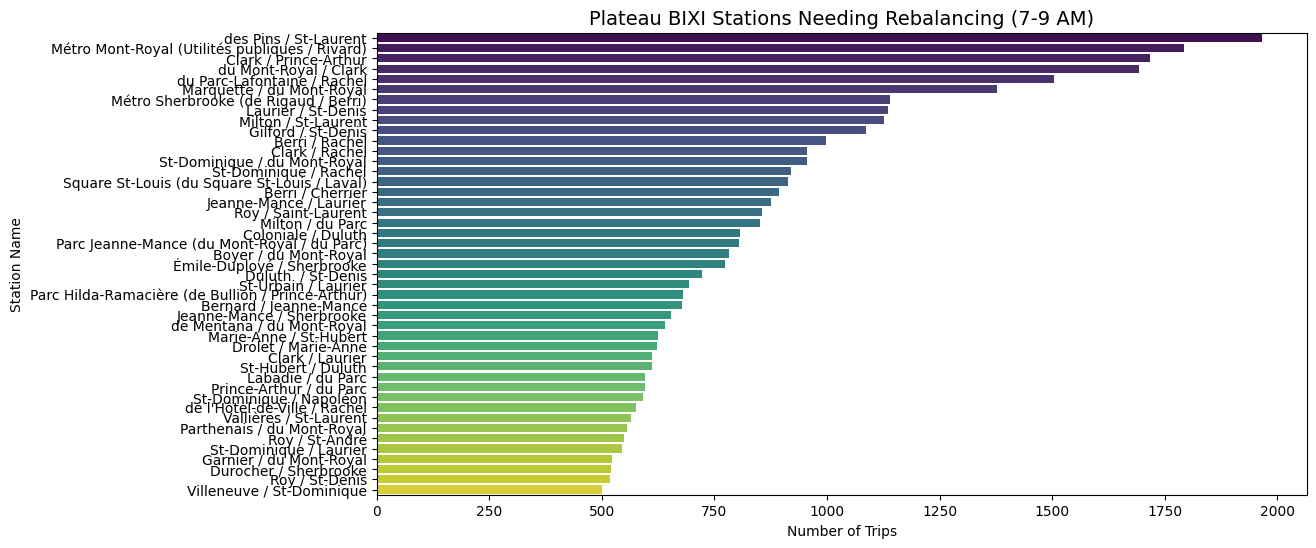

In [ ]:
#again lets filter trips that started in Plateau between 7-9 AM
plateau_peak_hours = bixi_data[(bixi_data['STARTSTATIONARRONDISSEMENT'].str.contains('Plateau', case=False, na=False)) &
                               (bixi_data['HOUR'] >= 7) & (bixi_data['HOUR'] <= 9)]

#count the number of trips for each station in Plateau
plateau_peak_usage = plateau_peak_hours.groupby('STARTSTATIONNAME').size().sort_values(ascending=False)

#apply the rebalancing recommendation logic to Plateau stations
def recommend_rebalancing(data, threshold=500):
    recommendations = data[data > threshold]
    return recommendations

#now get Plateau stations needing rebalancing
plateau_rebalancing_needed = recommend_rebalancing(plateau_peak_usage)

#display the Plateau stations that need rebalancing
print("\nPlateau Stations Needing Rebalancing (7-9 AM):")
print(plateau_rebalancing_needed)

#finally viz Plateau stations that need rebalancing
if not plateau_rebalancing_needed.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=plateau_rebalancing_needed.values, y=plateau_rebalancing_needed.index, palette='viridis')
    plt.title('Plateau BIXI Stations Needing Rebalancing (7-9 AM)', fontsize=14)
    plt.xlabel('Number of Trips')
    plt.ylabel('Station Name')
    plt.show()
else:
    print("\nNo Plateau stations need rebalancing based on the current threshold.")


# Voila, thats it! Thanks.

